In [9]:
import visa
#import traceback
import numpy as np
import matplotlib.pyplot as plt
import zhinst
import zhinst.utils
from tqdm import tqdm
import time

In [2]:
class N5244A_instrument:
    
    def __init__(self, address):
        self.address = address
        
    def connect(self):
        try:
            self.inst = visa.ResourceManager().open_resource(self.address, read_termination='\n')
            #check connection status
            command = "*IDN?"
            return_str = self.inst.query(command)
            if ("N5244A" in return_str):return "No error"
            else: return "Error:N5244A:Connection"
        except: return "Error:N5244A:connect"

                
    def configure_CW(self, frequence, ifPowerOn, power, ifAverage, averaging_factor, IF_BW):
        try:
            self.inst = visa.ResourceManager().open_resource(self.address, read_termination='\n')
            #==== default setting ====
            self.inst.query("INITiate1:CONTinuous OFF;*OPC?")
            self.inst.write("SENSe1:SWEep:TRIGger:POINt OFF" )
            #set points
            points  = 1
            self.inst.write("SENSe1:SWEep:POINts " + str(points))
            #==== user setting ====
            #set averaging
            if (ifAverage == True):
                self.inst.write("SENS:AVER:STAT ON")  #set averaging_on
                self.inst.write("SENS:AVER:MODE POINT") #set point_averaging mode
                self.inst.write("SENS:AVER:COUN "+ str(averaging_factor))
            else: self.inst.write("SENS:AVER:STAT OFF")
            
            #set power
            if (ifPowerOn == True):            
                self.inst.write("OUTPUT ON")
                self.inst.write( "SOURce:POWer " + str(power))
            else: self.inst.write("OUTPUT OFF")

            #set IF BW (Hz)
            self.inst.write( "SENSe1:BANDwidth " + str(IF_BW))
            
            #set sweep mode
            self.inst.write("SENSe:SWEep:TYPE CW")
            #set CW frequence (GHz)
            self.inst.write( "SENSe:FREQuency:CW " + str(frequence*10**9))
            
            return "No error"
        except: return "Error:N5244A:configure_CW"

    #====================================================
    def set_trace(self):
        try:
            self.inst = visa.ResourceManager().open_resource(self.address, read_termination='\n')

            #deleta all before setting trace
            self.inst.write("CALCulate:PARameter:DELete:ALL")
            
            #-------- set trace --------
            #---- set Real(S21) ----
            #Creates a measurement but does NOT display it.
            self.inst.write( "CALCulate1:PARameter:DEFine:EXT '1', S12" )
            #Creates a new trace <tnum> and associates (feeds) a measurement <name> to the
            #specified window<wnum>. 
            self.inst.write("DISPlay:WINDow1:TRACe1:FEED '1'")
            #Sets the selected measurement. 
            self.inst.write( "CALCulate1:PARameter:SELect '1'" )
            #set format
            self.inst.write( "CALCulate1:FORMat REAL" )
            self.inst.write("CALCulate1:MARKer:STATe ON") #set marker
            
            #---- set Imag(S21) ----
            self.inst.write( "CALCulate1:PARameter:DEFine:EXT '2', S12" )
            self.inst.write( "DISPlay:WINDow1:TRACe2:FEED '2'" )
            self.inst.write( "CALCulate1:PARameter:SELect '2'" )
            self.inst.write( "CALCulate1:FORMat IMAGinary" )
            self.inst.write("CALCulate1:MARKer:STATe ON") #set marker
            
            #---- set R(S21) ----
            self.inst.write("CALCulate1:PARameter:DEFine:EXT '3', S12")
            self.inst.write("DISPlay:WINDow1:TRACe3:FEED '3'")
            self.inst.write("CALCulate1:PARameter:SELect '3'")
            self.inst.write("CALCulate1:FORMat MLOGarithmic")
            self.inst.write("CALCulate1:MARKer:STATe ON") #set marker
            
            #---- set Phase(S21) ----
            self.inst.write( "CALCulate1:PARameter:DEFine:EXT '4', S12" )
            self.inst.write( "DISPlay:WINDow1:TRACe4:FEED '4'" )
            self.inst.write( "CALCulate1:PARameter:SELect '4'" )
            self.inst.write( "CALCulate1:FORMat PHASe" ) 
            self.inst.write("CALCulate1:MARKer:STATe ON") #set marker
            
            #marker properties
            self.inst.write("DISP:WIND:ANN:MARK:SIZE LARG") #marker size
            self.inst.write("CALCulate1:MARKer:COUP ON")    #marker coupled
            self.inst.write("CALCulate1:MARKer:DISC ON")    #marker discrete
        
            return "No error"
        except: return "Error:N5244A:set_trace"
        
    def initiate_and_read_data(self):
        try:
            self.inst = visa.ResourceManager().open_resource(self.address, read_termination='\n')
            #initiate or trigger
            self.inst.write("INITiate1")
            #wait for completing operation
            self.inst.write("*OPC?")
            while True:
                try: self.inst.read();break
                except:pass
                
            #---- read data ----
            #x axis
            data_str = self.inst.query("CALCulate1:X?").split(",")
            X_axis   = list(map(float, data_str) )

            #select measurement            
            self.inst.write("CALCulate1:PARameter:SELect '1'")
            #set format
            self.inst.write("FORMat ASCII")
            #read data
            data_str = self.inst.query("CALCulate1:DATA? FDATA").split(",")
            S12_real = list(map(float, data_str) )

            #select measurement
            self.inst.write("CALCulate1:PARameter:SELect '2'")
            #set format
            self.inst.write("FORMat ASCII")
            #read data
            data_str = self.inst.query("CALCulate1:DATA? FDATA").split(",")
            S12_imag = list(map(float, data_str) )

            #select measurement
            self.inst.write( "CALCulate1:PARameter:SELect '3'" )
            #set format
            self.inst.write( "FORMat ASCII" )
            #read data
            data_str = self.inst.query("CALCulate1:DATA? FDATA").split(",")
            S12_R = list(map(float, data_str) )

            #select measurement
            self.inst.write("CALCulate1:PARameter:SELect '4'")
            #set format
            self.inst.write("FORMat ASCII")
            #read data
            data_str = self.inst.query("CALCulate1:DATA? FDATA").split(",")
            S12_phase = list(map(float, data_str) )
            
            #convert unit if sweepType = LINear frequence
            sweepType= self.inst.query("SENSe:SWEep:TYPE?")
            if (sweepType == "LIN"): X_axis = list(map(lambda freq: freq/10**9, X_axis))#convert Hz to GHz
            
            return [X_axis   , S12_real   , S12_imag   , S12_R   , S12_phase   , "No error"]
        except: return [[float("NAN")]]*5+[["Error:N5244A:initiate_and_read_data"]]

In [39]:
#=====================================================================
if __name__ == "__main__":
    address = "GPIB0::5::INSTR"
    #address = "TCPIP0::127.0.0.1::33566::SOCKET"
    inst    = N5244A_instrument(address)
       
    #----  check connection ----
    error_info = inst.connect()
    print("Connection:", error_info)
    
    #----------------------------------------------------------------------
    print();print();print("CW: ")
    
    #---- configure sweepFreuence ----
    frequence        = 1     #unit: GHz
    ifPowerOn        = True
    power            = -10   #unit: dBm
    ifAverage        = True
    averaging_factor = 11
    IF_BW            = 10    #unit: Hz
    error_info = inst.configure_CW(frequence, ifPowerOn, power, ifAverage, averaging_factor, IF_BW)
    print("Configure:", error_info)

    #---- set trace ----
    error_info = inst.set_trace()
    print("Set_trace:", error_info)
    
    #---- initiate measurement and read data ----
    [X_axis, S12_real, S12_imag, S12_R, S12_phase, error_info] = np.array(inst.initiate_and_read_data())
    #print(X_axis)
    #print( S12_real, S12_imag, S12_R, S12_phase )
    print("Loss ", S12_R[0], ", Phase: ", S12_phase[0] )

Connection: No error


CW: 
Configure: No error
Set_trace: No error
Loss  -44.60687 , Phase:  -97.46735


用母对母头代替HMC928，测量线路的损耗：-1.203535 dB

In [40]:
device_id    = 'dev2374'
apilevel     = 6
(daq, device, _) = zhinst.utils.create_api_session(device_id, apilevel)

daq.setInt('/dev2374/auxouts/0/outputselect', -1)

Discovered device `dev2374`: UHFLI with options .
Creating an API session for device `dev2374` on `127.0.0.1`, `8004` with apilevel `6`.


In [53]:
Vin_vec   = np.linspace(0,10,21)
phase_vec = np.zeros(Vin_vec.size)
loss_vec  = np.zeros(Vin_vec.size)

for n_Vin in tqdm(range(Vin_vec.size)):
    Vin = Vin_vec[n_Vin]
    
    #set Vin
    daq.setDouble('/dev2374/auxouts/0/offset', Vin)
    time.sleep(0.2)
    #read data
    [X_axis, S12_real, S12_imag, S12_R, S12_phase, error_info] = np.array(inst.initiate_and_read_data())
    loss_vec[n_Vin] = S12_R[0] - (-1.203535)
    phase_vec[n_Vin]= S12_phase[0]

100%|███████████████████████████████████████████| 21/21 [00:28<00:00,  1.35s/it]


In [57]:
#phase_back_vec = phase_vec
#phase_vec = phase_back_vec
#phase_vec[8:] = phase_vec[8:] + 360

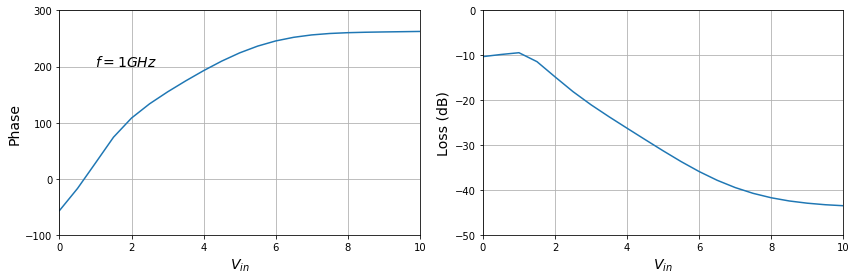

In [65]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(Vin_vec, phase_vec)
plt.xlim([Vin_vec[0],Vin_vec[-1]])
plt.ylim([-100, 300])
plt.xlabel(r'$V_{in}$', fontsize=14)
plt.ylabel('Phase', fontsize=14)
plt.yticks(np.linspace(-100,300,5))
plt.text(1, 200, r'$f = 1GHz$', fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.plot(Vin_vec, loss_vec)
plt.xlim([Vin_vec[0],Vin_vec[-1]])
plt.ylim([-50, 0])
plt.xlabel(r'$V_{in}$', fontsize=14)
plt.ylabel('Loss (dB)', fontsize=14)
plt.grid()

plt.tight_layout()
plt.savefig("pic_name.png", format='png', dpi=200)